# Scenario notes

Using the NOAA SLR scenarios we can do a couple different iterations 

NOAA SLR Scenarios  https://coast.noaa.gov/slr/#/layer/sce/0/-17821114.951125123/1934329.2023005919/3/satellite/60/0.8/2090/interHigh/midAccretion

Year 2040
Intermediate Low : 0.72ft 0.22m 
Intermediate : 1.02ft
Intermediate High : 1.38ft
High : 1.71ft
Extreme : 1.94ft  0.59m

                    
Year 2090               
Intermediate Low : 1.84ft  0.56m
Intermediate : 3.44ft
Intermediate High : 5.15ft
High : 6.92ft
Extreme : 8.33ft  2.54m


Three scenarios to model, and present ranges from:  

2040
Low : 0.72ft 0.22m  to  Extreme : 1.94ft  0.59

Year 2090 No change in climate
Low : 1.84ft  0.56m  to Extreme : 8.33ft  2.54m

Year 2090 RCP4.5  climate  
Low : 1.84ft  0.56m  to Extreme : 8.33ft  2.54m


Thus need 6 model runs with the following levels: 






Notes and limitations: 
- While the subsidence induced SLR is likely not factored into these predictions the amount of total subsidence as projected by Han is in the range of 30-40 cm, with 



In [2]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))
 
# %matplotlib inline

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients

import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

#import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join("..", "..", 'RISA_yr6_GIT_ignored_files', 'Flo_py_wrkspace5_SLR2ft')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
tempspace = os.path.join(workspace, "temp")
#make sure workspace directory exists
if not os.path.exists(tempspace):
    os.makedirs(tempspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
pd.set_option('display.max_rows', 75)

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.

# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 16:38:51) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


# Model geometry notes


model boundaries square at 
X	Y
- 530200	8425825
- 537700	8425825
- 537700	8418325
- 530200	8418325

with length of 7500 m on both sides


next steps 
- try and just follow existing github model notebook 

Shapefile Boundaries: (530200.0, 8418325.0, 537700.0000000009, 8425825.000000002)
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace5_SLR2ft\Model_polyarea.shp
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace5_SLR2ft\Model_grid.shp


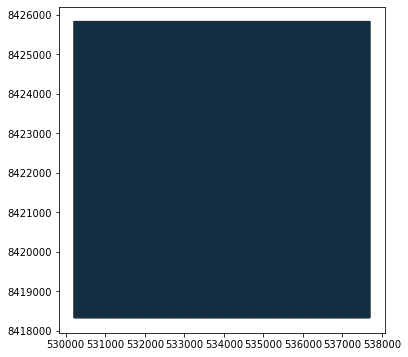

In [3]:
''' Define the number of layers, rows and columns.'''
# Note works at 100, 150, 300, 750, 1500
# Does not work at 600

ncol = 1500
nrow = 1500
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
# these are the bondaries of the shapefile
shp_xmin = round(ra.geometry[0].bounds[0],1)
shp_ymin = round(ra.geometry[0].bounds[1],1)
shp_xmax = round(ra.geometry[0].bounds[2],1)
shp_ymax = round(ra.geometry[0].bounds[3],1)
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))  

xll = int(shp_xmin)  # Lower left corner of model grid  
yll = int(shp_ymin)   # Lower left corner of model grid 


# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)/ncol))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)/nrow))   # the height of eech cell
delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc   

# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}    

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations from a DEM

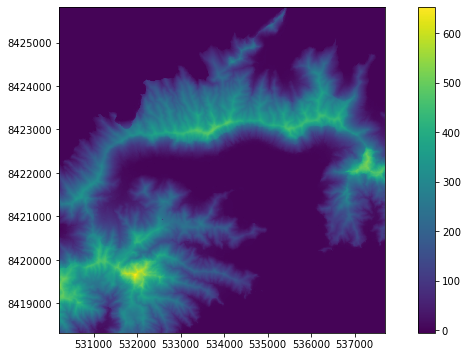

In [4]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..",  'Data/Raw/GIS/3m_DEM', '3m_dem_cp.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

Starting heads will be tricky.  Easiest might be to assign starting heads of 0.01 in ocean, then heads of 10 m less than top elevation in land surface areas, if optimization yields different starting heads then can modify. could also use the ending heads from the regional model. 


overall, I bound needs to be 

### starting heads
##### - Note need to change the land ocean if changing the coastline position 
##### - also need to change the Ocean_starting_head to whatever the scenario is 

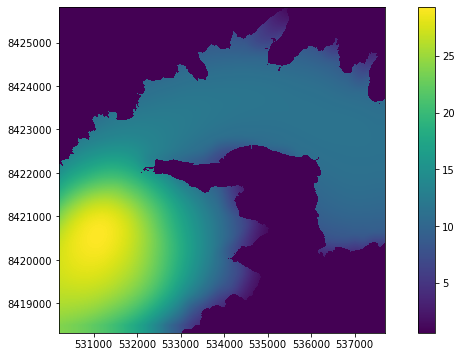

In [5]:
Ocean_starting_head = 0.6   # in meters 



## First import regional heads from the regional model

Raster_2_Clip = os.path.join("..",  'Data/Raw/From_regional', 'PyPCGA_model_Heads_Clip.tif')
Clipped_raster = os.path.join(workspace, "PyPCGA_model_Heads_Clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
regional_Heads = f(x2, y2)

#botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
#top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations


# then explicitly say that the ocean area has a specified head, since the regional heads are fuzzy

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds/For_heads', 'Land_Ocean_SLR2ft.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['OceanCell'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
mask = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

masked_heads = abs(regional_Heads)*mask                        # set ocean cells to a negative number through multoplication with -1
start_heads = np.where(masked_heads < 0, Ocean_starting_head, masked_heads) # Set ocean cells (defined as any negative values in the array) to Ocean_starting_head value

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(start_heads, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### make new ibound and specified head 


##### - Note need to change theibound_specHd_w_100m_buff_SLR8ftif changing the coastline position 


- Negative ibound (-1) is constant head
- Ibound of (0) is inactive
- Any positive Ibound (1) is variable head (active) 

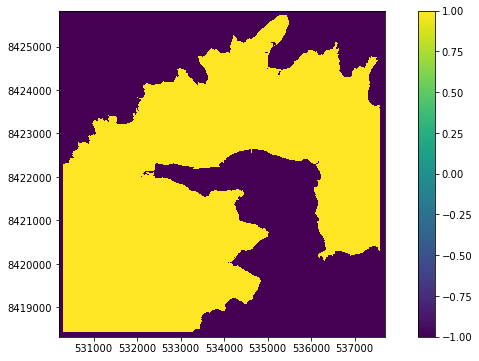

In [6]:
#### Use a Tutuila polygon to define the model active area as the island 

with fiona.open(os.path.join("..", 'Data/Raw/GIS/ibounds', 'ibound_specHd_w_100m_buff_SLR2ft.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Create Drains 
this takes a minute

<ipython-input-7-e3749dd6b312>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] > 100] = intersections['RastVal'] - 50
<ipython-input-7-e3749dd6b312>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] > 10] = intersections['RastVal'] - 1
<ipython-input-7-e3749dd6b312>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastV

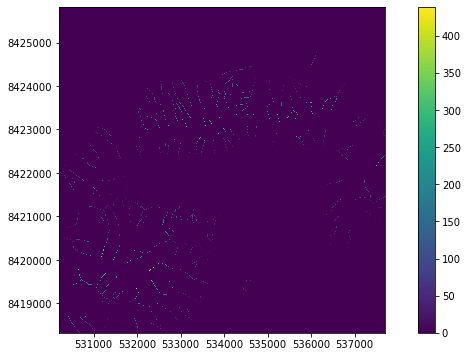

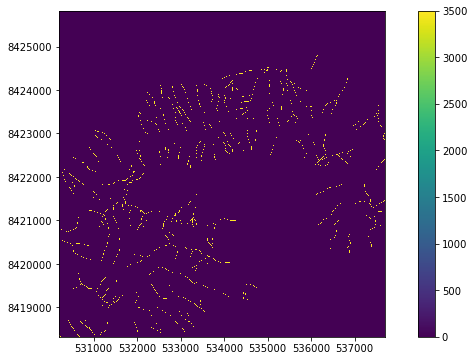

In [7]:
conductance_value = 3500

# Intersect streams with the grid cells using GEOPANDAS!! :)
lines = geopandas.GeoDataFrame.from_file(os.path.join("..", "Data/Raw/GIS", "Streams", 'Streams_All_WGS2S.shp'))
poly = geopandas.GeoDataFrame.from_file(os.path.join(workspace, 'Model_grid.shp'))
# Do the spatial intersect to just pull out cells that hit streams
intersections= geopandas.sjoin(poly, lines, how="inner", op='intersects')
intersections["x"] = intersections.centroid.x # pull out the x coordiate
intersections["y"] = intersections.centroid.y # pull out the y coordiate
intersections["Cond"] = conductance_value
# Write the geopandas dataframe to a esri shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# Extract elevation values to the points from the DEM
Clipped_DEM_raster = os.path.join(workspace, "DEM_10m_clip.asc")   # from the DEM used above
src = rasterio.open(Clipped_DEM_raster) 
coords = [(x,y) for x, y in zip(intersections["x"], intersections["y"])]  # This woll pull the cooordinate values out of the centrods of the intersections frame above
intersections['RastVal'] = [x[0] for x in src.sample(coords)]


# Modify elevations a bit
intersections['RastVal'][intersections['RastVal'] > 100] = intersections['RastVal'] - 50
intersections['RastVal'][intersections['RastVal'] > 10] = intersections['RastVal'] - 1
intersections['RastVal'][intersections['RastVal'] > 3] = intersections['RastVal'] - 1
intersections['RastVal'][intersections['RastVal'] > 2] = intersections['RastVal'] - 1
intersections['RastVal'][intersections['RastVal'] > 1] = intersections['RastVal'] - .5

# Reset any values that ended up as 0s
intersections['RastVal'][intersections['RastVal'] <= Ocean_starting_head] = Ocean_starting_head  #(will make pink box)

# Write to shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually


# Create a model square array with the point values elevation as the elevation 
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['RastVal'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_elev = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_elev, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

# Create a model square array with the point values conductance defined as whatever.
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Cond'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_conductance = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_conductance, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)


# Save in Flopy friendly format
drnElv_lst = pd.DataFrame({
                 'lay':  0,
                 'row':  np.nonzero(Stream_elev)[0], # + 1,
                 'col':  np.nonzero(Stream_elev)[1], # + 1,
                 'elv':  Stream_elev[np.nonzero(Stream_elev)],
                 'cond': Stream_conductance[np.nonzero(Stream_conductance)]}, 
             columns=['lay', 'row', 'col', 'elv', 'cond'])

# Convert the DataFrame into a list of lists for the drn constructor
stress_period_data = drnElv_lst.values.tolist()

# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_drain = {0: stress_period_data}    

### Pumping wells 
Using ASPA data and the average pumprates 2005-2017 based only last wells pumprate master sheet 

In [8]:
Pump_wells = pd.read_csv(os.path.join("..",  'Data/Raw/GIS/Pump_wells', 'ASPA_wells_clip_UTM2s.csv'))

Pump_wells['col_num'] = Pump_wells['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pump_wells['row_num'] = Pump_wells['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pump_wells['rowcol']  = list(zip(Pump_wells.row_num, Pump_wells.col_num)) 

# This takes obs wells that occupy the same cell and averages them! 
Unique_PumpWells = Pump_wells.groupby('rowcol', as_index=False).sum()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_PumpWells["name"] = "PumpWellCell_"+Unique_PumpWells.index.map(str)

# set layer values 
Unique_PumpWells["Layer"] = 0

# Convert GPM to m3/d
Unique_PumpWells["m3pd"] = Unique_PumpWells["PumpGMP"]*-5.45099

SP_frame = Unique_PumpWells[['Layer', 'row_num', 'col_num', 'm3pd']]

stress_period_data = SP_frame.values.tolist()
# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_PmpWells = {0: stress_period_data}

### Observation points

note need to cut out obs that are not within the model domain

In [ ]:
Pdevel_WLs = pd.read_csv(os.path.join("..",  'Data/Raw/Water_levels', 'Predevelop_WLs_MOD_vai183.csv'))

# Cut out observations that are outside of the model square (dont need the y's but could add those too for shoots and giggls
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] > shp_xmin]
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] < shp_xmax]

Pdevel_WLs['col_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pdevel_WLs['row_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['row_num'].astype(int))
colvals = list(Unique_WLs['col_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

In [ ]:
SWB_output_recharge = os.path.join("..",  'Data/Raw/GIS/Recharge','Normalized_RCP4p5_Net_Infil.asc')    # Normalized_RCP4p5_Net_Infil        net_infiltration_annual_Base

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [ ]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

In [ ]:
# set the  values this cell is set up for optimization
HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

## Initial starting point before 3-4 rounds of calibration  was calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5, 5]
#calgood =  [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1], [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75]  calgood = [1.3, 27, 11.5, 0.3, 1.2, 0.27, 0.00158, 0.73, 0.42, 0.38, 0.003 , 1.6] #0.000003

calgood = [0.89, 24.0, 5.1, 0.5, 1.5, 0.39, 0.002, 1.6, 0.36, 0.43, 0.0039, 0.92]#  ~2.6 errort



#calgood =  [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1]


Alluvium_Aua      = calgood[0]
Alluvium_Fagaalu  = calgood[1]
Alluvium_minor    = calgood[2]
Alluvium_Utulei   = calgood[3]
Alluvium_Vaipito  = calgood[4]
Alluvium_Vatia    = calgood[5]
Dikes             = calgood[6]
Pago_inner_E      = calgood[7]
Pago_inner_W      = calgood[8]
Pago_outer        = calgood[9]
Trachyte          = calgood[10]
Alluvium_Laulii   = calgood[11]


map_dic = {-12:Alluvium_Aua, 
           -14:Alluvium_Fagaalu, 
           -15:Alluvium_minor,
           -13:Alluvium_Utulei,
           -11:Alluvium_Vaipito,
           -10:Alluvium_Vatia,
           -50:Dikes,
           -30:Pago_inner_E,
           -40:Pago_inner_W,
           -20:Pago_outer,
           -60:Trachyte, 
           -16:Alluvium_Laulii}

for i in map_dic:
    HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)
    
HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, the number Should not actually maatter at all!

#HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
#HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10


In [ ]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
#### ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)

# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

# Run model 

if needed: #### Model checker
https://notebook.community/brclark-usgs/flopy/examples/Notebooks/flopy3_ModelCheckerExample
- ml.check()

In [ ]:
ml.write_input()
ml.run_model(silent=False)

In [ ]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,90)
plt.xlim(0,90)

plt.plot([0,20,65],[0,20,65], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))
print("but remember, the model should be calibrated to a no well scenario, so dont worry about this") 

In [ ]:
esri_is_the_lamest_program_ever = "SLR2ft_RCP45"

## Post process, map and extract results to heads raster file

In [ ]:
# develop geometry to plot heads as colormap
N = np.array([ncol, nrow, nlay])
dx = np.array([delc, delr, abs(botm)])
Lx = delc*ncol
Ly = delr*nrow
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)

# Extract heads data
hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])
minv = 0
maxv = head.max()

# Plot em
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Lyr 1 Heads', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

# Write the heads layer(s) to a raster file
# export head rasters 
output_raster = os.path.join(workspace, 'heads_{}.asc'.format(esri_is_the_lamest_program_ever))   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, head[0])

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

### Calculate Depth to water


In [ ]:
# Super basic depth to water calculation, Currently allows for negative depths (i.e. flooding)
Heads_raw = np.loadtxt(os.path.join(workspace, 'heads_{}.asc'.format(esri_is_the_lamest_program_ever)), skiprows=6)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6
Dep_to_wat = top-Heads_raw

# Write the GIS asc raster from the NP array 
output_raster = os.path.join(workspace, 'dep2Wat_{}.asc'.format(esri_is_the_lamest_program_ever))   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, Dep_to_wat)

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)
    
    
if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Dep_to_wat, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)